# Example Simple RAG

In [2]:
!pip install ragatouille
!pip install chromadb weaviate weaviate-client langchain langchain-ollama langchain-community langchain-huggingface --upgrade 


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached protobuf-5.28.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached grpcio-1.67.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
INFO: pip is looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
  Using cached opentelemetry_exporter_otlp_proto_common-1.27.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.27.0-py3-none-any.whl.metadata (2.3 kB)
INFO: pip is still looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for

In [11]:
import chromadb
import weaviate
from weaviate.embedded import EmbeddedOptions
import weaviate.classes as wvc
from weaviate.classes.config import Configure
import pandas as pd
import sqlite3
from ragatouille import RAGPretrainedModel
import ollama
from typing import Optional
import langchain
from langchain.text_splitter import TokenTextSplitter
import os
import requests
import json

## Define the Corpus

In [3]:
tables = {}
texts = {}

datastore_directory = '../example_data'

for file in os.listdir(datastore_directory):
    filename = os.fsdecode(file)
    path = os.path.join(datastore_directory, filename)
    if filename.endswith(".csv") or filename.endswith(".xlsx"):
        print(f"Found table: {filename}")
        table = pd.read_csv(path)
        tables[f'{filename}'] = table
    elif filename.endswith(".txt"):
        print(f"Found text: {filename}")
        text = open(path, "r")
        texts[f'{filename}'] = text.read()

Found text: Castle_in_the_Sky.txt
Found text: Hayao_Miyazaki.txt
Found text: Studio_Ghibli.txt


In [24]:
tables['WMT_Grocery_202209.csv']

,SHIPPING_LOCATION,DEPARTMENT,CATEGORY,SUBCATEGORY,BREADCRUMBS,SKU,PRODUCT_URL,PRODUCT_NAME,BRAND,PRICE_RETAIL,PRICE_CURRENT,PRODUCT_SIZE,PROMOTION,RunDate,tid
0,79936,Deli,"Hummus, Dips, & Salsa",NaN,"Deli/Hummus, Dips, & Salsa",110895339,https://www.walmart.com/ip/Marketside-Roasted-...,"Marketside Roasted Red Pepper Hummus, 10 Oz",Marketside,2.67,2.67,10,NaN,2022-09-11 21:20:04,16163804
1,79936,Deli,"Hummus, Dips, & Salsa",NaN,"Deli/Hummus, Dips, & Salsa",105455228,https://www.walmart.com/ip/Marketside-Roasted-...,"Marketside Roasted Garlic Hummus, 10 Oz",Marketside,2.67,2.67,10,NaN,2022-09-11 21:20:04,16163805
2,79936,Deli,"Hummus, Dips, & Salsa",NaN,"Deli/Hummus, Dips, & Salsa",128642379,https://www.walmart.com/ip/Marketside-Classic-...,"Marketside Classic Hummus, 10 Oz",Marketside,2.67,2.67,10,NaN,2022-09-11 21:20:04,16163806
3,79936,Deli,"Hummus, Dips, & Salsa",NaN,"Deli/Hummus, Dips, & Salsa",366126367,https://www.walmart.com/ip/Marketside-Everythi...,"Marketside Everything Hummus, 10 oz",Marketside,2.67,2.67,10,NaN,2022-09-11 21:20:04,16163807
4,79936,Deli,"Hummus, Dips, & Salsa",NaN,"Deli/Hummus, Dips, & Salsa",160090316,https://www.walmart.com/ip/Price-s-Jalapeno-Di...,"Price's Jalapeno Dip, 12 Oz.",Price's,3.12,3.12,12,NaN,2022-09-11 21:20:04,16163808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568529,70072,Alcohol,Wine,White Wine,Alcohol/Wine,593600139,https://www.walmart.com/ip/Farm-Fresh-Blueberr...,Farm Fresh Blueberry Moscato 750ml,Farm Fresh Wine Company,9.98,9.98,750,NaN,2022-09-11 21:20:04,16732333
568530,70072,Alcohol,Wine,White Wine,Alcohol/Wine,333403243,https://www.walmart.com/ip/Farm-Fresh-Peach-Mo...,Farm Fresh Peach Moscato 750 Ml,Farm Fresh Wine Company,9.98,9.98,750,NaN,2022-09-11 21:20:04,16732334
568531,70072,Alcohol,Wine,White Wine,Alcohol/Wine,526588325,https://www.walmart.com/ip/Farm-Fresh-Raspberr...,Farm Fresh Raspberry Moscato 750ml,Farm Fresh Wine Company,9.98,9.98,750,NaN,2022-09-11 21:20:04,16732335
568532,70072,Alcohol,Wine,White Wine,Alcohol/Wine,286992782,https://www.walmart.com/ip/Farm-Fresh-Mango-Mo...,Farm Fresh Mango Moscato 750ml,Farm Fresh Wine Company,9.98,9.98,750,NaN,2022-09-11 21:20:04,16732336


In [25]:
print(texts['Studio_Ghibli.txt'])

Studio Ghibli, Inc. (Japanese: 株式会社スタジオジブリ, Hepburn: Kabushiki-gaisha Sutajio Jiburi) is a Japanese animation studio based in Koganei, Tokyo. It has a strong presence in the animation industry and has expanded its portfolio to include various media formats, such as short subjects, television commercials, and two television films. Their work has been well-received by audiences and recognized with numerous awards. Their mascot and most recognizable symbol, the character Totoro from the 1988 film My Neighbor Totoro, is a giant spirit inspired by raccoon dogs (tanuki) and cats (neko). Among the studio's highest-grossing films are Princess Mononoke (1997), Spirited Away (2001), Howl's Moving Castle (2004), Ponyo (2008), and The Boy and the Heron (2023). Studio Ghibli was founded on June 15, 1985, by the directors Hayao Miyazaki and Isao Takahata and producer Toshio Suzuki, after acquiring Topcraft's assets.
Four of the studio's films are among the ten highest-grossing Japanese feature films

In [54]:
corpus['CATEGORY'].isna().sum()

0

## Preprocess Corpus

In [61]:
corpus_tables = []

for file in tables:
    table_chunks = {}
    table = tables[f'{file}']
    for category in table['CATEGORY']:
        table_chunks[category] = {}
    for row in range(len(table)):
        category = table['CATEGORY'][row]
        brand = table['BRAND'][row]
        if brand not in table_chunks[category]:
            table_chunks[category][brand] = [table.loc[row]]
        else:
            table_chunks[category][brand].append([table.loc[row]])
    for category in table_chunks:
        for brand in table_chunks[category]:
            temp_docs = []
            for doc in range(len(table_chunks[category][brand])):
                for string in range(len(table_chunks[category][brand][doc])):
                    temp_docs.append(table_chunks[category][brand][0].index[string])
                    temp_docs.append(table_chunks[category][brand][doc][string])
            corpus_tables.append(" ".join(str(x) for x in temp_docs))

In [42]:
chunker = TokenTextSplitter(chunk_size=1000, chunk_overlap=100)
corpus_texts = []
for file in texts:
    split = chunker.split_text(texts[f'{file}'])
    for chunked_text in split:
        corpus_texts.append(chunked_text)

In [69]:
print(len(corpus_texts))
print(len(corpus_tables))
print(corpus_texts[0])
print(corpus_tables[4])

32
9865
Castle in the Sky (Japanese: 天空の城ラピュタ, Hepburn: Tenkū no Shiro Rapyuta), also known as Laputa: Castle in the Sky, is a 1986 Japanese animated fantasy adventure film written and directed by Hayao Miyazaki. It was produced by Isao Takahata, animated by Studio Ghibli, and distributed by the Toei Company. In voice acting roles, the original Japanese version stars Mayumi Tanaka, Keiko Yokozawa, Kotoe Hatsui, and Minori Terada. The film follows orphans Sheeta and Pazu, who are pursued by government agent Muska, the army, and a group of pirates. They seek Sheeta's crystal necklace, the key to accessing Laputa, a legendary flying castle hosting advanced technology.
Castle in the Sky is the first film to be animated by Studio Ghibli. Its production team included many of Miyazaki's longtime collaborators, who would continue to work with the studio for the following three decades. The film was partly inspired by Miyazaki's trips to Wales, where he witnessed the aftermath of the 1984–1985 

In [73]:
db_ids = []
db_metadatas = []
db_docs = []
i = 0
if len(corpus_tables) > 0:
    for doc in corpus_tables:
        db_ids.append(f"{i+1}")
        i+=1
        db_metadatas.append({'filetype':'table','file':'placeholder'})
        db_docs.append(doc)
if len(corpus_texts) > 0:
    for doc in corpus_texts:
        db_ids.append(f"{i+1}")
        i+=1
        db_metadatas.append({'filetype':'text','file':'placeholder'})
        db_docs.append(doc)

In [75]:
print(len(db_ids))
print(len(db_metadatas))
print(len(db_ids))

9897
9897
9897


## Load Corpus into Chroma

In [110]:
chroma_client = chromadb.PersistentClient(path="./split_chroma")
#chroma_client.delete_collection(name="ghibli") # In case we need to redo anything
collection = chroma_client.get_or_create_collection(name="grocery")

In [34]:
chroma_client = chromadb.PersistentClient(path="./newer_chroma")
#chroma_client.delete_collection(name="ghibli") # In case we need to redo anything
collection = chroma_client.get_or_create_collection(name="grocery")

In [2]:
chroma_client = chromadb.PersistentClient(path="./chroma")
#chroma_client.delete_collection(name="ghibli") # In case we need to redo anything
collection = chroma_client.get_or_create_collection(name="grocery")

In [111]:
# Take the lists and load them into chromadb

batch_size = 10000
batch_count = (len(docs) - 1) // batch_size + 1

for batch in range(batch_count):
    db_docs = docs[batch*batch_size:(batch+1)*batch_size]
    db_ids = ids[batch*batch_size:(batch+1)*batch_size]
    db_metadata = metadata[batch*batch_size:(batch+1)*batch_size]
    print(f"Adding batch {batch}/{batch_count} to vector store")
    collection.add(documents=db_docs, ids=db_ids, metadatas=db_metadata)

Adding batch 0/1 to vector store


In [122]:
# Display an example search against chromadb

results = collection.query(
    query_texts=["How much does shrimp cost?"],
    n_results=1
)
print(results)

{'ids': [['4400']], 'distances': [[0.9189187288284302]], 'metadatas': [[{'brand': 'Pacific Seafood', 'category': 'Fresh Food'}]], 'embeddings': None, 'documents': [['SHIPPING_LOCATION 85225 DEPARTMENT Meat & Seafood CATEGORY Fresh Food SUBCATEGORY Seafood BREADCRUMBS Meat & Seafood/Fresh Food SKU 210567362 PRODUCT_URL https://www.walmart.com/ip/Frozen-Wild-Coldwater-Salad-Shrimp-1-lb-350-500-Count-per-lb/210567362?fulfillmentIntent=Pickup PRODUCT_NAME Frozen Wild Coldwater Salad Shrimp, 1 lb (350-500 Count per lb) BRAND Pacific Seafood PRICE_RETAIL 8.36 PRICE_CURRENT 8.36 PRODUCT_SIZE 1 PROMOTION nan RunDate 2022-09-11 21:20:04 tid 16489619']], 'uris': None, 'data': None, 'included': ['metadatas', 'documents', 'distances']}


## Load Corpus into Weviate

In [6]:
data = pd.read_csv('../example_data/WMT_Grocery_202209.csv')

/tmp/ipykernel_61809/4242776727.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../example_data/WMT_Grocery_202209.csv')


In [82]:
client = weaviate.WeaviateClient(
    embedded_options=EmbeddedOptions(
        additional_env_vars={
            "ENABLE_MODULES": "text2vec-ollama",
        },
        persistence_data_path="../weaviate"
    )
)

{"action":"startup","build_git_commit":"'\"$GITHASH\"'","build_go_version":"go1.22.0","build_image_tag":"localhost","build_wv_version":"1.26.6","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-11-04T16:30:17-06:00"}
{"action":"startup","auto_schema_enabled":true,"build_git_commit":"'\"$GITHASH\"'","build_go_version":"go1.22.0","build_image_tag":"localhost","build_wv_version":"1.26.6","level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-11-04T16:30:17-06:00"}
{"build_git_commit":"'\"$GITHASH\"'","build_go_version":"go1.22.0","build_image_tag":"localhost","build_wv_version":"1.26.6","level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-11-04T16:30:17-06:00"}
{"build_git_commit":"'\"$GITHASH\

In [124]:
client.connect()
client.collections.create(
    name="Groceries",
    vectorizer_config=[Configure.NamedVectors.text2vec_ollama(name = "grocery_vector", model = "all-minilm")]
)

{"build_git_commit":"'\"$GITHASH\"'","build_go_version":"go1.22.0","build_image_tag":"localhost","build_wv_version":"1.26.6","level":"warning","msg":"prop len tracker file ../weaviate/groceries/NsEdFTWWfVFq/proplengths does not exist, creating new tracker","time":"2024-11-04T17:04:26-06:00"}
{"action":"hnsw_prefill_cache_async","build_git_commit":"'\"$GITHASH\"'","build_go_version":"go1.22.0","build_image_tag":"localhost","build_wv_version":"1.26.6","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2024-11-04T17:04:26-06:00","wait_for_cache_prefill":false}
{"build_git_commit":"'\"$GITHASH\"'","build_go_version":"go1.22.0","build_image_tag":"localhost","build_wv_version":"1.26.6","level":"info","msg":"Created shard groceries_NsEdFTWWfVFq in 6.080603ms","time":"2024-11-04T17:04:26-06:00"}
{"action":"hnsw_vector_cache_prefill","build_git_commit":"'\"$GITHASH\"'","build_go_version":"go1.22.0","build_image_tag":"localhost","build_wv_version":"1.26.6"

In [62]:
ollama.pull('all-minilm')

{'status': 'success'}

In [14]:
grocery_objs = list()
for index, row in data.iterrows():
  grocery_objs.append({
    "category": row['CATEGORY'],
    "product": row['PRODUCT_NAME'],
    "subcategory": row['SUBCATEGORY'],
    "brand": row['BRAND'],
    "price": row['PRICE_RETAIL'],
    "current_price": row['PRICE_CURRENT'],
    "department": row['DEPARTMENT'],
  })



In [116]:
tables = {}
tables['WMT_Grocery_202209.csv'] = data
corpus_tables = []

for file in tables:
    table_chunks = {}
    table = tables[f'{file}']
    for category in table['CATEGORY']:
        table_chunks[category] = {}
    for row in range(len(table)):
        category = table['CATEGORY'][row]
        brand = table['BRAND'][row]
        if brand not in table_chunks[category]:
            table_chunks[category][brand] = [table.loc[row]]
        else:
            table_chunks[category][brand].append([table.loc[row]])
    for category in table_chunks:
        for brand in table_chunks[category]:
            temp_docs = []
            for doc in range(len(table_chunks[category][brand])):
                for string in range(len(table_chunks[category][brand][doc])):
                    temp_docs.append(str(table_chunks[category][brand][0].index[string]))
                    temp_docs.append(str(table_chunks[category][brand][doc][string]))
            corpus_tables.append({'file': file, 'category': category, 'brand': brand, 'products': " ".join(str(x) for x in temp_docs)})

/tmp/ipykernel_61809/1639880631.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_docs.append(str(table_chunks[category][brand][doc][string]))


In [96]:
table_chunks['Hummus, Dips, & Salsa']['Marketside'][0].index

Index(['SHIPPING_LOCATION', 'DEPARTMENT', 'CATEGORY', 'SUBCATEGORY',
       'BREADCRUMBS', 'SKU', 'PRODUCT_URL', 'PRODUCT_NAME', 'BRAND',
       'PRICE_RETAIL', 'PRICE_CURRENT', 'PRODUCT_SIZE', 'PROMOTION', 'RunDate',
       'tid'],
      dtype='object')

In [121]:
corpus_tables[0]

{'file': 'WMT_Grocery_202209.csv',
 'category': 'Hummus, Dips, & Salsa',
 'brand': 'Marketside',
 'products': 'SHIPPING_LOCATION 79936 DEPARTMENT Deli CATEGORY Hummus, Dips, & Salsa SUBCATEGORY nan BREADCRUMBS Deli/Hummus, Dips, & Salsa SKU 110895339 PRODUCT_URL https://www.walmart.com/ip/Marketside-Roasted-Red-Pepper-Hummus-10-Oz/110895339?fulfillmentIntent=Pickup PRODUCT_NAME Marketside Roasted Red Pepper Hummus, 10 Oz BRAND Marketside PRICE_RETAIL 2.67 PRICE_CURRENT 2.67 PRODUCT_SIZE 10 PROMOTION nan RunDate 2022-09-11 21:20:04 tid 16163804 SHIPPING_LOCATION SHIPPING_LOCATION                                                79936\nDEPARTMENT                                                        Deli\nCATEGORY                                         Hummus, Dips, & Salsa\nSUBCATEGORY                                                        NaN\nBREADCRUMBS                                 Deli/Hummus, Dips, & Salsa\nSKU                                                          105455228\n

In [120]:
grocery_objs[5]

{'category': 'Hummus, Dips, & Salsa',
 'product': "Price's Green Chili Dip, 12 Oz.",
 'subcategory': nan,
 'brand': "Price's",
 'price': 3.12,
 'current_price': 3.12,
 'department': 'Deli'}

In [125]:
groceries = client.collections.get("Groceries")

for table in corpus_tables:
    groceries.data.insert(table)

UnexpectedStatusCodeError: Object was not added! Unexpected status code: 400, with response body: {'code': 400, 'message': 'parsing body body from "" failed, because invalid character \'N\' looking for beginning of value'}.

In [110]:
groceries = client.collections.get("Groceries")

batch_size = 1000
batch_count = (len(grocery_objs) - 1) // batch_size + 1
with groceries.batch.dynamic() as batch:
  for i in range(batch_count):
    print(f"Working on batch {i+1}/{batch_count}")
    groceries.data.insert_many(grocery_objs[i*batch_size:(i+1)*batch_size])

Working on batch 1/569


WeaviateInvalidInputError: Invalid input provided: Argument 'properties' must be one of: [typing.Mapping], but got <class 'list'>.

In [ ]:
groceries = client.collections.get("Groceries")

batch_size = 1000
batch_count = (len(table_chunks) - 1) // batch_size + 1
with groceries.batch.dynamic() as batch:
  for i in range(batch_count):
    print(f"Working on batch {i+1}/{batch_count}")
    groceries.data.insert_many(grocery_objs[i*batch_size:(i+1)*batch_size])

In [50]:
client.connect()

WeaviateConnectionError: Connection to Weaviate failed. Details: Error: All connection attempts failed. 
Is Weaviate running and reachable at http://localhost:8079?

In [51]:
question = "How much does shrimp cost?"

try:
    #pass # Replace with your code. Close client gracefully in the finally block.
    groceries = client.collections.get("Groceries")

    response = groceries.query.near_text(
        query=question,
        limit=5
    )

    print(response.objects)

finally:
    client.close()

AssertionError: 

## Testing with Ollama

In [47]:
model = OllamaLLM(model="llama3.1")
chain = create_sql_query_chain(model, db)
response = chain.invoke({"question": "How much does beer cost"})
response

'However, I need to inform you that there is no column for "beer" in the provided tables.\n\nBut I can help you with a query that will return all products with their prices. Then we can filter the results to find the price of beer if it was present.\n\nSQLQuery: SELECT `"PRICE_CURRENT"` FROM `"WalMart'

In [7]:
# Define the reranker

llmreranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

/home/mist861/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/mist861/anaconda3/lib/python3.11/site-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [118]:
# The below takes the prompt, performs a retrieval against chromadb, reranks it, then calls ollama. I did not make (most) of this, it's derived from: https://huggingface.co/learn/cookbook/en/advanced_rag

def rag_query(
    question: str,
    llm: str,
    knowledge_index=collection,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 5,
    num_docs_final: int = 1):
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.query(query_texts=question, n_results=num_retrieved_docs)
    relevant_docs = relevant_docs['documents'][0]

    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)

    relevant_docs = relevant_docs[:num_docs_final]

    final_prompt = f"""
        You are a helpful assistant. Use the provided context to answer the provided question. 
        The attribute names of each item are set in UPPERCASE followed by the attribute value.
        For example, the cost or price of an item follows the term "PRICE_CURRENT".
        
        CONTEXT: {relevant_docs}
        QUESTION: {question}
        
        """

    response = ollama.chat(model=llm, messages=[
        {
            'role': 'user',
            'content': final_prompt,
        },
    ])
    answer = response['message']['content']

    return answer, relevant_docs

In [123]:
# Perform a retrieval/generations without the reranker

question="How much does shrimp cost?"
result, docs = rag_query(question, 'llama3.1')
print(result)

=> Retrieving documents...
According to the provided context, the current price of the shrimp is $8.36, which is indicated by the attribute name "PRICE_CURRENT".


In [50]:
# Display the retrieved documents used

print(docs)
len(docs)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



5

In [ ]:
# Perform a retrieval/generation with the reranker

result, docs = rag_query(question, 'llama3.1', reranker=llmreranker)

=> Retrieving documents...
=> Reranking documents...


/home/mist861/anaconda3/lib/python3.11/site-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


In [16]:
print(result)

I don't know. There is no mention of hummus in the provided context.


In [17]:
print(docs)

[{'content': '60007 Deli Deli Meat & Cheese nan Deli/Deli Meat & Cheese 483646515 https://www.walmart.com/ip/Great-Value-Original-Pepperoni-Mega-Pack-21-oz/483646515?fulfillmentIntent=Pickup Great Value Original Pepperoni Mega Pack, 21 oz Great Value 7.68 7.68 21 nan 2022-09-11 21:20:04 16174372', 'score': 7.5078125, 'rank': 0, 'result_index': 14}, {'content': '48180 Deli Deli Meat & Cheese nan Deli/Deli Meat & Cheese 433305422 https://www.walmart.com/ip/Great-Value-Honey-Ham-Mega-Pack-lunchmeat-22-ounce/433305422?fulfillmentIntent=Pickup Great Value Honey  Ham Mega Pack lunchmeat, 22 ounce Great Value 6.98 6.98 22 nan 2022-09-11 21:20:04 16253260', 'score': 7.4375, 'rank': 1, 'result_index': 4}, {'content': '48180 Deli Deli Meat & Cheese nan Deli/Deli Meat & Cheese 483646515 https://www.walmart.com/ip/Great-Value-Original-Pepperoni-Mega-Pack-21-oz/483646515?fulfillmentIntent=Pickup Great Value Original Pepperoni Mega Pack, 21 oz Great Value 7.68 7.68 21 nan 2022-09-11 21:20:04 1625328

# Field of Broken Dreams (Discarded Snippets)

In [ ]:
corpus = pd.read_csv('../data_raw/WMT_Grocery_202209.csv')
corpus

In [ ]:
sqlcon = sqlite3.connect("./sqllite/walmart.db")

In [ ]:
os.chmod("./sqllite/walmart.db", 774)
corpus.to_sql("WalMart", sqlcon)

In [ ]:
os.chmod("./sqllite/walmart.db", 444)

In [ ]:
cursor = sqlcon.cursor()
cursor.execute("SELECT PRICE_RETAIL FROM WalMart WHERE CATEGORY='Beer';")
print(cursor.fetchall())

In [ ]:
db = SQLDatabase.from_uri("sqlite:///sqllite/walmart.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT PRICE_RETAIL FROM WalMart WHERE CATEGORY='Beer' LIMIT 10;")

In [ ]:
chunks = {}
for category in corpus['CATEGORY'].unique():
    chunks[category] = []
print(chunks)

In [ ]:
len(corpus.groupby('BRAND')['CATEGORY'])

In [ ]:
chunks = {}
for category in corpus['CATEGORY'].unique():
    chunks[category] = {}
print(chunks)

In [ ]:
for row in range(len(corpus)):
    category = corpus['CATEGORY'][row]
    brand = corpus['BRAND'][row]
    if brand not in chunks[category]:
        chunks[category][brand] = [corpus.loc[row]]
    else:
        chunks[category][brand].append([corpus.loc[row]])

In [ ]:
print(len(chunks))
print(len(chunks['Frozen Desserts']['Great Value']))

In [ ]:
chunks['Frozen Desserts']['Great Value'][0].index

In [ ]:
ids = []
metadata = []
docs = []
i = 0
for category in chunks:
    for brand in chunks[category]:
        temp_docs = []
        ids.append(f"{i+1}")
        i+=1
        metadata.append({'category':category, 'brand':brand})
        for doc in range(len(chunks[category][brand])):
            for string in range(len(chunks[category][brand][doc])):
                temp_docs.append(chunks[category][brand][0].index[string])
                temp_docs.append(chunks[category][brand][doc][string])
        docs.append(" ".join(str(x) for x in temp_docs))

# Results

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
import pandas as pd
import numpy as np

In [35]:
results = pd.read_csv('../../results/5542-0001_project-llm-results.csv')
results = results.drop('Notes', axis=1)
results

,Model,Size (GB),Parameters (B),Accuracy (Estimated w/ Test Prompts)
0,llama3.1,4.700,8.03,0.580
1,llama3.2,2.000,3.21,0.730
2,llama3.2:1B,1.300,1.24,0.650
3,qwen2.5,4.700,7.62,0.800
4,qwen2.5:0.5B,0.394,0.50,0.200
5,phi3.5,2.200,3.80,0.600
6,mistral,4.200,7.25,0.830
7,gemma,5.000,8.54,0.250
8,gemma2:2b,1.600,2.61,0.225


[Text(0, 0.5, 'Percentage Accuracy'),
 Text(0.5, 1.0, 'Model Estimated Accuracy Scores')]

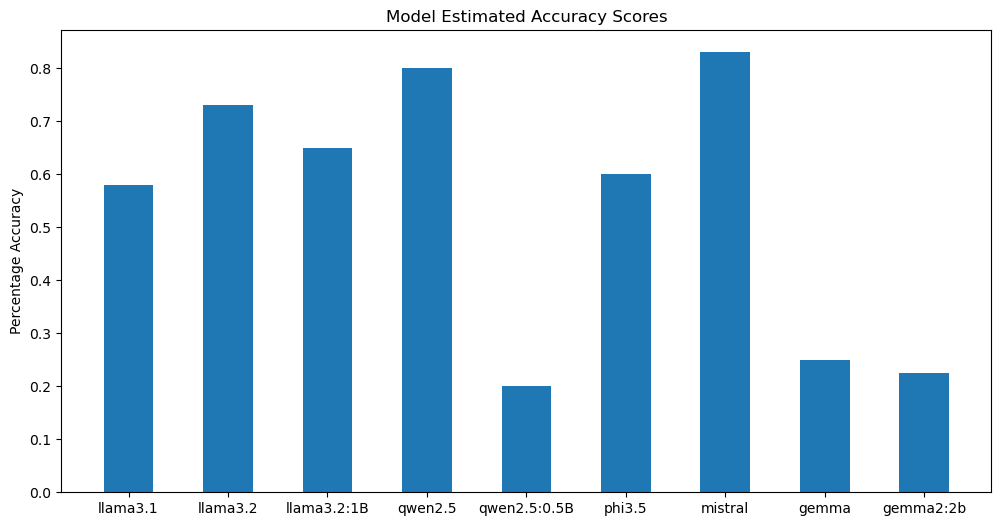

In [36]:
results = results.rename(columns={"Size (GB)": "Size", "Parameters (B)": "Parameters", "Accuracy (Estimated w/ Test Prompts)": "Accuracy"})

fig, ax = plt.subplots(figsize=(12,6))
bar_container = ax.bar(results.Model, results.Accuracy, width=0.5)
ax.set(ylabel='Percentage Accuracy', title='Model Estimated Accuracy Scores')

[Text(0, 0.5, 'Size (GB)'), Text(0.5, 1.0, 'Model Size Comparison')]

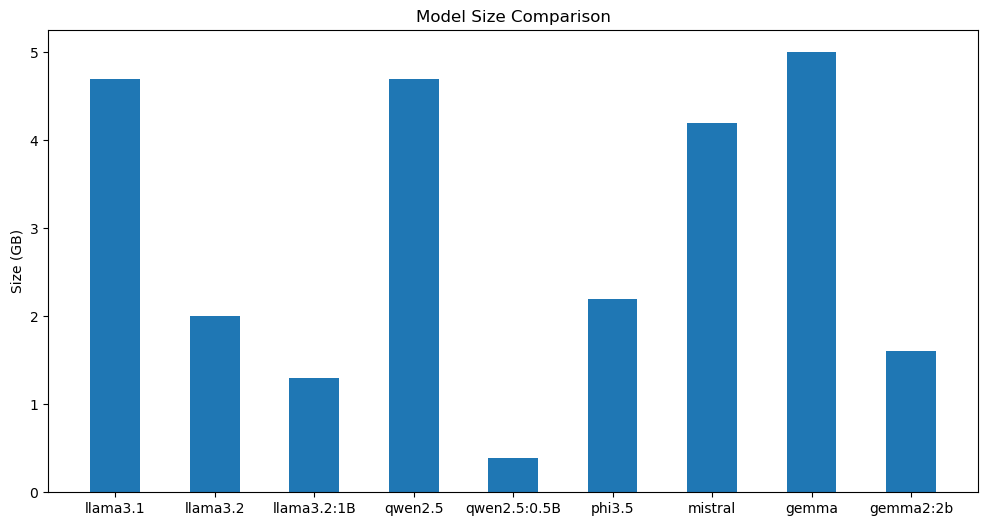

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
bar_container = ax.bar(results.Model, results.Size, width=0.5)
ax.set(ylabel='Size (GB)', title='Model Size Comparison')

[Text(0, 0.5, 'Parameters (B)'), Text(0.5, 1.0, 'Model Parameters Comparison')]

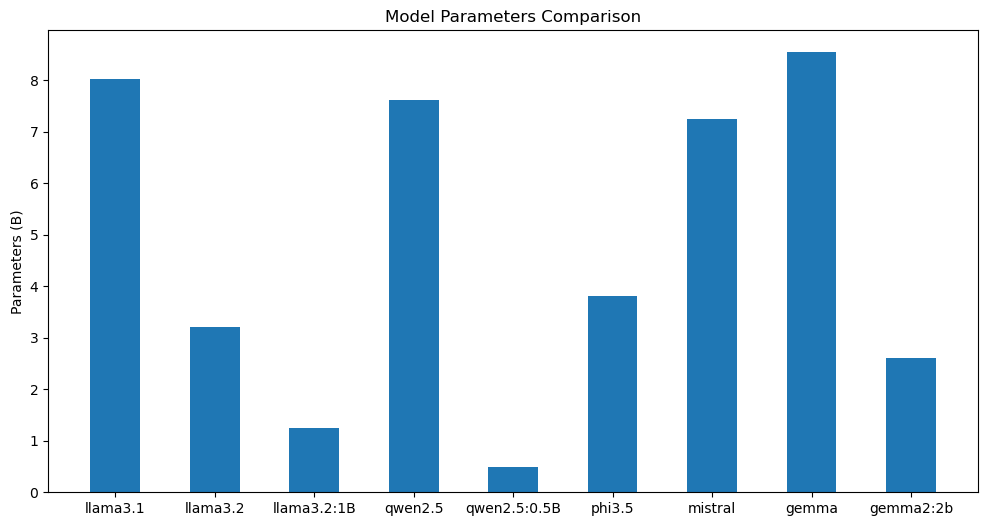

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
bar_container = ax.bar(results.Model, results.Parameters, width=0.5)
ax.set(ylabel='Parameters (B)', title='Model Parameters Comparison')